<a href="https://colab.research.google.com/github/TRhine/PRA3024_BigData/blob/main/GravWaves_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf
import sys
!{sys.executable} -m pip install lalsuite pycbc



--2021-02-22 17:40:19--  https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57824232 (55M)
Saving to: ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’

H-H1_LOSC_CLN_4_V1- 100%[===================>]  55.14M  33.7MB/s    in 1.6s    

2021-02-22 17:40:21 (33.7 MB/s) - ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ saved [57824232/57824232]

--2021-02-22 17:40:21--  https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62070438 (59M)
Saving to: ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’

L-L1_LOSC_CLN_4_V1- 100%[===================>]  59.19M  34.7MB/s    in 1.7s    

20

# **ASSIGNMENT 1**

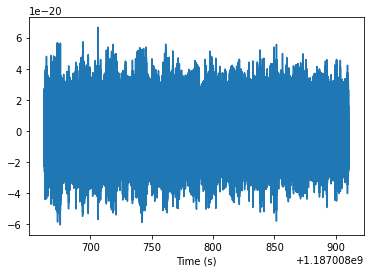

In [5]:
#EXERCISE 1: MATCHED FILTERING
%matplotlib inline 
import pylab 
from pycbc.filter import highpass 
from pycbc.catalog import Merger 
from pycbc.frame import read_frame 
 
merger = Merger("GW170817") 
strain, stilde = {}, {} 
for ifo in ['H1', 'L1']: 
   # We'll download the data and select 256 seconds that includes the event time 
   ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo), 
                   '{}:LOSC-STRAIN'.format(ifo), 
                  start_time=merger.time - 224, 
                  end_time=merger.time + 32, 
                  check_integrity=False) 
   
   # Read the detector data and remove low frequency content 
   strain[ifo] = highpass(ts, 15) 
 
   # Remove time corrupted by the high pass filter 
   strain[ifo] = strain[ifo].crop(4, 4) 
   
   # Also create a frequency domain version of the data    
   stilde[ifo] = strain[ifo].to_frequencyseries() 
 
 
#print (strain.delta_t) 
pylab.plot(strain['H1'].sample_times, strain['H1']) 
pylab.xlabel('Time (s)') 
pylab.show() 

In [ ]:
#Eliminating PSD from DATA
from pycbc.psd import interpolate, inverse_spectrum_truncation
psds = {}
for ifo in ['L1', 'H1']:

# Calculate a psd from the data. We'll use 2s segments in a median -welch style estimate
# We then interpolate the PSD to the desired frequency step.
 psds[ifo] = interpolate(strain[ifo].psd(2), stilde[ifo].delta_f)

# We explicitly control how much data will be corrupted by overwhitening the data later on
# In this case we choose 2 seconds.
psds[ifo] = inverse_spectrum_truncation(psds[ifo], int(2 *
                                                        strain[ifo].sample_rate),
                                         low_frequency_cutoff=15.0,
                                         trunc_method='hann')

pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
pylab.xlim(20, 1024)
pylab.ylim(1e-47, 1e-42)
pylab.legend()

In [7]:
#Matched Filtering
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
import numpy
# We will try different component masses and see which gives us the largest
masses = numpy.arange(1.3, 1.5, .01)

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = []

for m in masses:  #Generate a waveform with a given component mass; assumed equal mass, nonspinning
  hp, hc = get_fd_waveform(approximant="TaylorF2",
                           mass1=m, mass2=m,
                           f_lower=20, delta_f=stilde[ifo].delta_f)
  hp.resize(len(stilde[ifo]))

# Matched filter the data and find the peak
max_snr, max_time = {}, {}
for ifo in ['L1', 'H1']:
  snr = matched_filter(hp, stilde[ifo], psd=psds[ifo],
                       low_frequency_cutoff=20.0)

# The complex SNR at the peak
snr = snr.time_slice(merger.time - 1, merger.time + 1)
_, idx = snr.abs_max_loc()
max_snr[ifo] = snr[idx]

# The time of the peak
max_time[ifo] = float(idx) / snr.sample_rate + snr.start_time

network_snr = (abs(numpy.array(list(max_snr.values()))) ** 2.0).sum()** 0.5
snrs.append(max_snr)

# Keep track of only the loudest peak
if network_snr > nsnr: 
  tmax, hmax, mmax, smax = max_time, hp, m, max_snr
  nsnr = network_snr

#print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mmax)
#Not sure what we're actually supposed to print here

We found the best Mass1=Mass2 was 1.49 solar masses (detector frame)


# **ASSIGNMENT 2**

**PART 1**

<function matplotlib.pyplot.show>

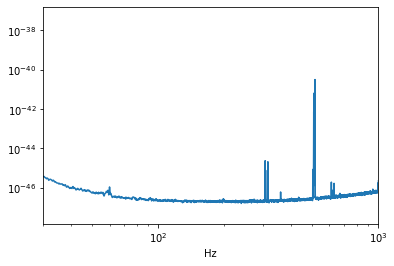

In [11]:
#PART 1
from pycbc.psd import welch, interpolate
import pycbc.types 
d = numpy.load('/content/noise_ts_4096Hz.npy')
import pycbc.types 
dt = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0])
Data = d

#Estimating PSD
delta_t = 1.0 / 4096
tsamples = int(128 / delta_t)

# Estimate the PSD
## We'll choose 4 seconds PSD samples that are overlapped 50 %
seg_len = int(4 / delta_t)
seg_stride = int(seg_len / 2)
psds = pycbc.psd.welch(Data,
                      seg_len=seg_len,
                      seg_stride=seg_stride)

pylab.loglog(psds.sample_frequencies, psds)
pylab.xlim(xmin=30, xmax = 1000)
pylab.xlabel('Hz')
pylab.show

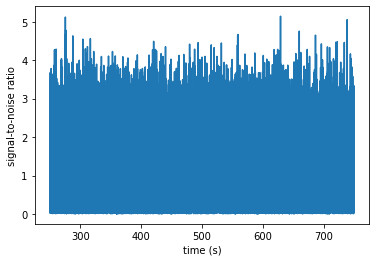

Maximum SNR 5.14255771068566


In [13]:
#PART 1 - Matched Filtering
from pycbc.psd import welch, interpolate
psds = interpolate(welch(d), 1.0 / d.duration)

import pycbc.noise
import pycbc.psd
import pycbc.filter
import pycbc.waveform
import pylab
flow = 30 #Hz
stilde = Data.to_frequencyseries()


hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                             mass1=10, mass2=10,
                             f_lower=flow, delta_f=stilde.delta_f)

hp.resize(len(stilde))  
snr = pycbc.filter.matched_filter(hp, stilde, psd=psds,
                                      low_frequency_cutoff=flow)


# Remove regions corrupted by filter wraparound
snr = snr[len(snr) // 4: len(snr) * 3 // 4]

pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('signal-to-noise ratio')
pylab.xlabel('time (s)')
pylab.show()
print ( 'Maximum SNR', max(abs(snr)) )


**ASSIGNMENT 2 - PART 2**

<function matplotlib.pyplot.show>

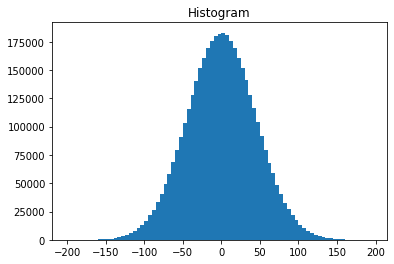

In [20]:
#PART 2 - Histogram Formation
 
white_data = (Data.to_frequencyseries() / psds**0.5).to_timeseries() 

import matplotlib.pyplot as plt
import seaborn as sns 

x = range(-200, 200, 5)
plt.title ("Histogram")
plt.hist(white_data, x)
plt.show
##Data reveals the expected gaussian distribution with zero mean#

**ASSIGNMENT 2 - PART 3**

In [ ]:
#PART 3 - Sationary Assumption

from pycbc.filter import sigmasq
SNR = (numpy.sum((4*hp*numpy.conj(hp)*hp.delta_f/psds).data).real)**0.5 

from pycbc.waveform import get_fd_waveform 
hp, hc = get_fd_waveform(approximant="TaylorF2", 
                         mass1=3, 
                         mass2=3, 
                         delta_f=1.0/(200.0) , 
                         distance = 500,  
                         f_lower=20.0, f_final = 2048.0)    #Luminosity distance = 500 Mpc 

max = 1000

Dataslice = len(Data)/max
Dataslice = int(Dataslice)
print(Dataslice)

SNR_all = []

for i in range(max):
  data_piece = Data[i*Dataslice : Dataslice*(i+1)]
  psds = pycbc.psd.interpolate(pycbc.psd.welch(data_piece), hp.delta_f)
  SNR = (pycbc.filter.sigmasq(hp,psds))**0.5
  #SNR calculation as seen previously
  SNR_all.append(SNR)

  print(SNR)
  #print(SNR_all)

<function matplotlib.pyplot.show>

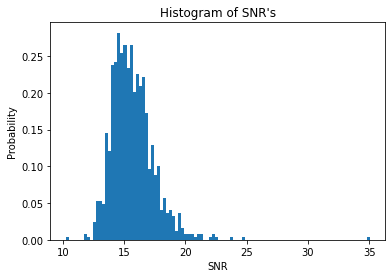

In [32]:
#Plot the histogram...
plt.hist(SNR_all, 100, density=True)
plt.title("Histogram of SNR's")
plt.xlabel("SNR")
plt.ylabel("Probability")

plt.show

# **ASSIGNMENT 3**

**PART 1 - LIGO**

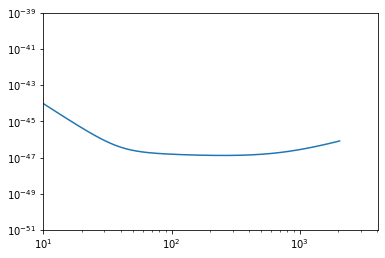

In [39]:
import pycbc.psd 
import numpy as np 
flow = 4.0   # set up the lower cut off frequency 
delta_f = 1.0 / 16 
flen = int(2048.0/ (delta_f)) + 1 
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow) 
 
psd.data[:int(flow/delta_f)] = np.inf  #set the value outside the frequency range to infinity 
psd.data[-1] = np.inf 

pylab.loglog(psd.sample_frequencies, psd)
pylab.xlim(10,4096)
pylab.ylim(1e-51,1e-39)
pylab.show()

**PART 2 - NO CLUE**

**PART 3 - EINSTEIN**

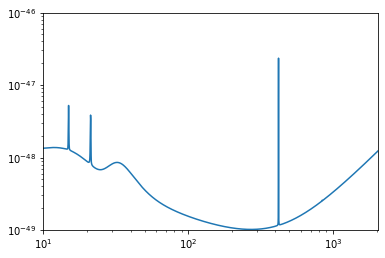

In [48]:
import pycbc.psd 
import numpy as np 
flow = 4.0   # set up the lower cut off frequency 
delta_f = 1.0 / 16 
flen = int(2048.0/ (delta_f)) + 1 
psd = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow) 
 
psd.data[:int(flow/delta_f)] = np.inf  #set the value outside the frequency range to infinity 
psd.data[-1] = np.inf 

pylab.loglog(psd.sample_frequencies, psd)
pylab.xlim(10,2048)
pylab.ylim(1e-49,1e-46)
pylab.show()